## Generative adversarial netwrorks

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tqdm as tqdm

# Torchvision datasets
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Types
from typing import Dict, List, Tuple
from torch import Tensor

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


# Set the random seed manually for reproducibility.
torch.manual_seed(1111)
np.random.seed(1111)

In [2]:
def show(img, ax=None):
    npimg = img.cpu().numpy()
    if ax is None:
      ax = plt
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

### Dataset

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST\raw\train-images-idx3-ubyte.gz to data/FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to data/FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data/FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data/FashionMNIST\raw



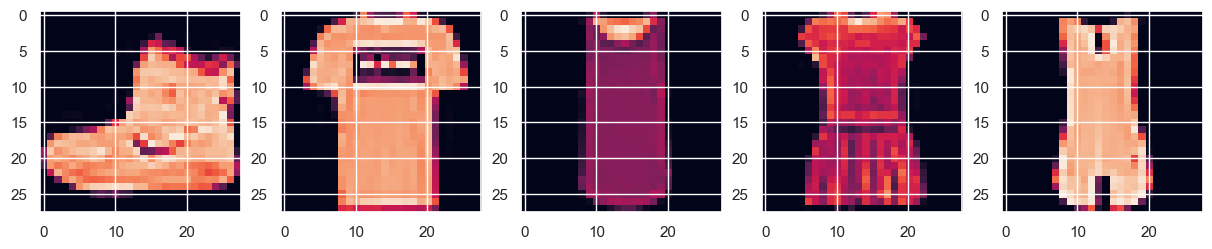

In [4]:
# Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1, 28*28)), # You can use any operation here
    # grey scale images
    transforms.Lambda(lambda x: x / 255)
])

dataset = datasets.FashionMNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Visualize some images
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    show(dataset[i][0], ax[i])

#### Generator
 
 A simple generator made with linear layers

In [5]:
class Generator(nn.Module):
    def __init__(self, cfg: Dict) -> None:
        super().__init__()
        self.cfg = cfg
        self.input_dim = cfg['input_dim']
        self.output_dim = cfg['output_dim']
        self.hidden_dim = cfg['hidden_dim']
        
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim * 2, self.output_dim),
            nn.Tanh()
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)
    
    @property
    def device(self) -> torch.device:
        return next(self.parameters()).device

#### Discriminator 

A simple discriminator made with linear layers

In [6]:
class Discriminator(nn.Module):
    def __init__(self, cfg: Dict) -> None:
        super().__init__()
        self.cfg = cfg
        self.input_dim = cfg['input_dim']
        self.output_dim = cfg['output_dim']
        
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512), # increase the output dimension for information gain
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid()
        )

    def forward(self, z: Tensor) -> Tensor:
        return self.net(z)

    @property
    def device(self) -> torch.device:
        return next(self.parameters()).device

### Training and qualitative evaluation of the results

In [7]:
generator_cfg = {
    'input_dim': 28 * 28,
    'output_dim': 28 * 28,
    'hidden_dim': 32
}

discriminator_cfg = {
    'input_dim': 28 * 28,
    'output_dim': 1
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
generator = Generator(generator_cfg)
discriminator = Discriminator(discriminator_cfg)

generator.to(device)
discriminator.to(device)

Discriminator(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

### The architecture data flow

Let us consider the generator and the discriminator two different functions defined over a space of dimension D = 28 * 28 (a flatten representation of the images): 

1. $g: R^D -> R^D$

2. $d: R^D -> R^1$, in this case $R^1$ is R (real numbers) but we will keep the notation for consistency

The generator $g$ will receive noise which will be mapped to the same space as an image from the dataset ($i$). Starting from noise, the function $g$ will try to mimic the images distribution by using the discriminator penalty twoards a point of equilibrium in which both networks are enough trained (a Nash Equilibrium point). At this point the $d$ won't be able to distinguish fake or generated images ($i_g$) from real ones ($i$).

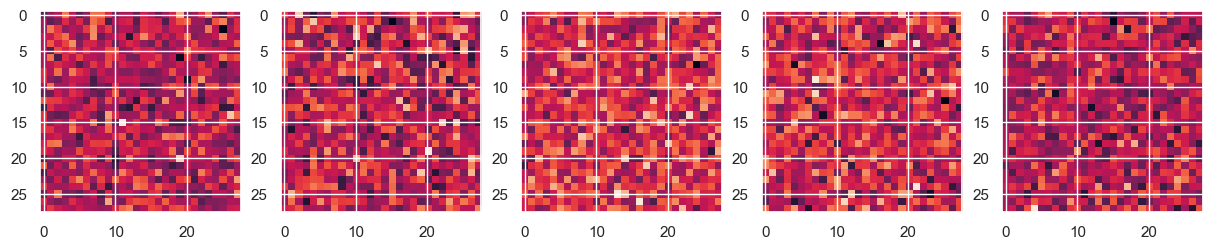

In [9]:
def noise_sample(n: int, dim: int) -> Tensor:
    return torch.randn(n, dim).to(device)

# Visualize some noise samples
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    show(noise_sample(1, 28*28).view(1, 28, 28), ax[i])

In [10]:
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
loss = nn.BCELoss() # classification loss

In [11]:
def join_training(
    generator: nn.Module,
    discriminator: nn.Module,
    generator_optimizer: torch.optim.Optimizer,
    discriminator_optimizer: torch.optim.Optimizer,
    loss: nn.Module,
    dataset: datasets.FashionMNIST,
    epochs: int = 10,
    batch_size: int = 128,
) -> None:
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Lists to keep track of progress
    generator_losses = []
    discriminator_losses = []

    # Number of batches
    num_batches = len(dataloader)

    for epoch in range(epochs):
        for idx, data in enumerate(dataloader):
            # 1. Train Discriminator
            real_images, _ = data
            real_images = real_images.view(-1, 28*28)
            real_images = real_images.to(device)

            # Generate fake images
            noise = noise_sample(batch_size, 28*28)
            fake_images = generator(noise)

            # Train on real images
            real_preds = discriminator(real_images)
            real_targets = torch.ones_like(real_preds)
            real_loss = loss(real_preds, real_targets)

            # Train on fake images
            fake_preds = discriminator(fake_images)
            fake_targets = torch.zeros_like(fake_preds)
            fake_loss = loss(fake_preds, fake_targets)

            # Backprop and optimize
            discriminator_loss = (real_loss + fake_loss) / 2
            discriminator_optimizer.zero_grad()
            discriminator_loss.backward()
            discriminator_optimizer.step()

            # 2. Train Generator
            # Generate fake images
            noise = noise_sample(batch_size, 28*28)
            fake_images = generator(noise)

            # Train on fake images
            preds = discriminator(fake_images)
            targets = torch.ones_like(preds)
            generator_loss = loss(preds, targets)

            # Backprop and optimize
            generator_optimizer.zero_grad()
            generator_loss.backward()
            generator_optimizer.step()

            if (idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{idx+1}/{num_batches}], Generator Loss: {generator_loss:.4f}, Discriminator Loss: {discriminator_loss:.4f}")

            generator_losses.append(generator_loss.item())
            discriminator_losses.append(discriminator_loss.item())

In [12]:
join_training(
    generator,
    discriminator,
    generator_optimizer,
    discriminator_optimizer,
    loss,
    dataset,
    epochs=10,
    batch_size=128
)

Epoch [1/10], Step [100/469], Generator Loss: 6.0624, Discriminator Loss: 0.0173
Epoch [1/10], Step [200/469], Generator Loss: 8.2060, Discriminator Loss: 0.0044
Epoch [1/10], Step [300/469], Generator Loss: 8.1023, Discriminator Loss: 0.0132
Epoch [1/10], Step [400/469], Generator Loss: 5.6425, Discriminator Loss: 0.0699
Epoch [2/10], Step [100/469], Generator Loss: 8.8422, Discriminator Loss: 0.0132
Epoch [2/10], Step [200/469], Generator Loss: 7.6779, Discriminator Loss: 0.0158
Epoch [2/10], Step [300/469], Generator Loss: 5.7058, Discriminator Loss: 0.0355
Epoch [2/10], Step [400/469], Generator Loss: 8.4303, Discriminator Loss: 0.0095
Epoch [3/10], Step [100/469], Generator Loss: 9.0248, Discriminator Loss: 0.0160
Epoch [3/10], Step [200/469], Generator Loss: 9.9089, Discriminator Loss: 0.0024
Epoch [3/10], Step [300/469], Generator Loss: 8.0579, Discriminator Loss: 0.0217
Epoch [3/10], Step [400/469], Generator Loss: 8.3446, Discriminator Loss: 0.0366
Epoch [4/10], Step [100/469]

### Observing the latent space

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


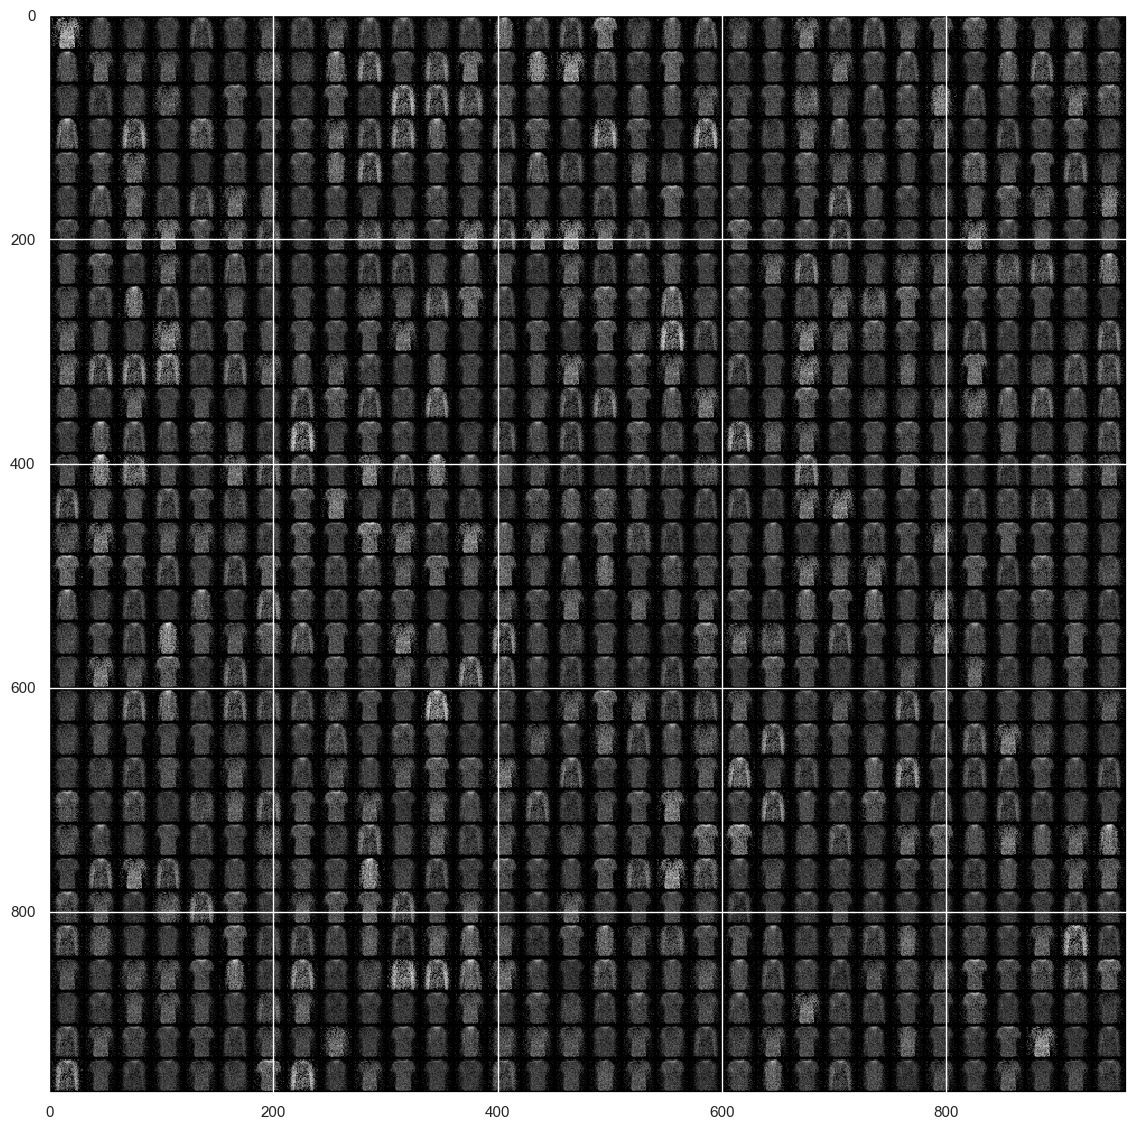

In [13]:
# Visualize some generated images
zs = noise_sample(32 * 32, 28 * 28)
fantasies = generator(zs).view(32 * 32, 28, 28)
img1 = make_grid(fantasies.view(32 * 32, 1, 28, 28), nrow=32)
fig, ax = plt.subplots(figsize=(14, 14))
show(img1, ax);

### Preliminary conclusions

- After join training we have a discriminative model of a specific accuracy $\lambda$ and a trained generator.
- By plotting the latent space or the generated samples (a large number of them) we can see that the samples don't look quite similar in terms of quality.

In [14]:
# Compute the discriminator's accuracy for real samples
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
real_images, _ = next(iter(dataloader))
real_images = real_images.view(-1, 28*28)
real_images = real_images.to(device)
real_preds = discriminator(real_images)
real_preds = real_preds > 0.5 # This will generate a boolean tensor with True if the prediction is > 0.5 and False otherwise
real_acc = real_preds.sum().item() / real_preds.shape[0]
print(f"Discriminator's accuracy for real samples: {real_acc:.4f}")

Discriminator's accuracy for real samples: 0.9922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


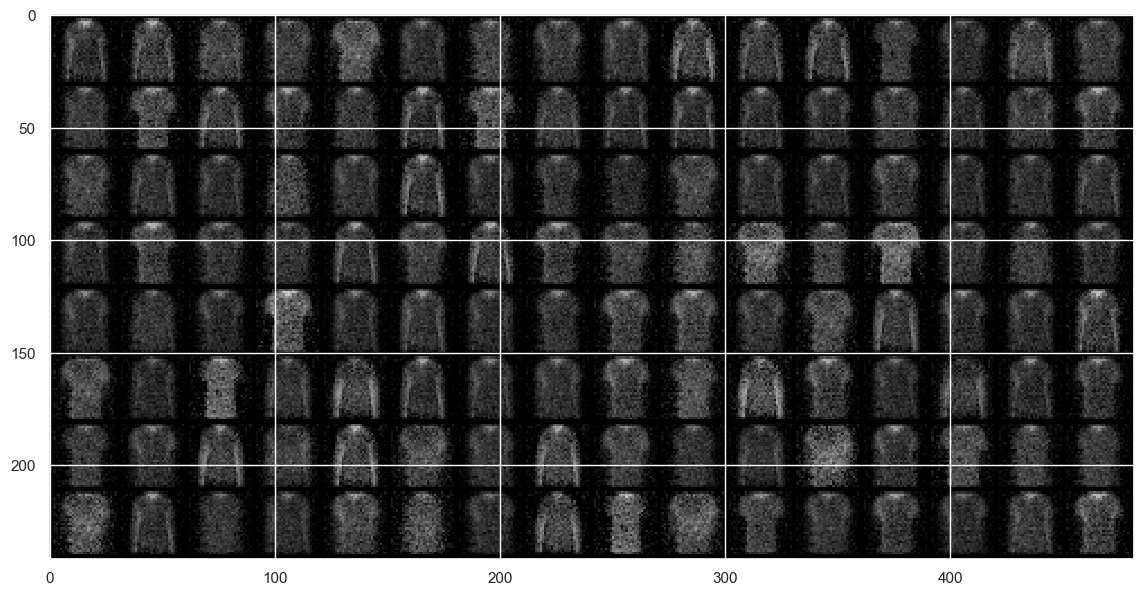

In [48]:
# Generate fake images
noise = noise_sample(128, 28*28)
fake_images = generator(noise)

# Plot the gnerated samples
img2 = make_grid(fake_images.view(128, 1, 28, 28), nrow=16)
fig, ax = plt.subplots(figsize=(14, 14))
show(img2, ax);